# Implementation of ATP
Credit to Naresh M. Patel for the Half-Latency Rule for Finding the Knee of the Latency Curve (https://dl.acm.org/doi/10.1145/2825236.2825248)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
example_data = pd.read_csv('output/128k_rw/10/fio.csv').set_index('io_depth')
example_data.sort_index(inplace=True)
# throughput = example_data.total_throughput
throughput = example_data.total_throughput / example_data.total_throughput.max()
latency = example_data.avg_latency
x=0.715
relative_important_of_throughput = 1 # alpha in the paper



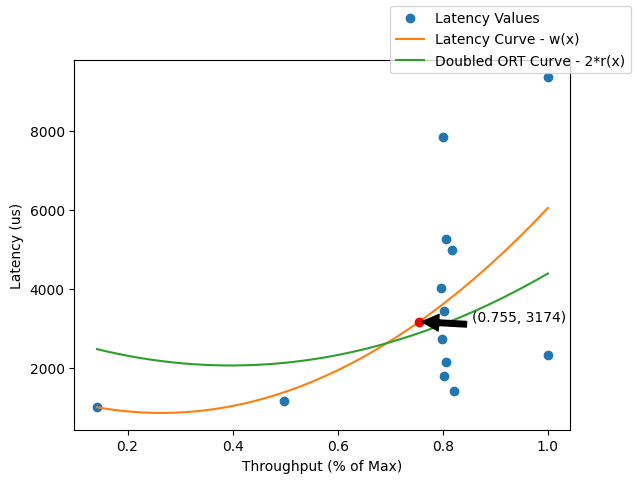

In [25]:
import scipy.integrate as spi

latency_curve = np.polynomial.polynomial.Polynomial.fit(x=throughput, y=latency, deg=2, w=1/throughput) # w(u)
throughput_x_range = np.linspace(throughput.min(), throughput.max(), 1000)
latency_mathed = latency_curve(throughput_x_range) # w(x) over the range 0,x

def r(x:float , w) -> float:
    """
    Computes the integral (1 / x) * integral(from 0 to x) of { w(u) du }
    
    Args:
    x (float): upper limit of integration
    w (function): a function that returns the value of w(u) for a given u
    
    Returns:
    The value of the integral
    """
    def integrand(u):
        return w(u)
    
    numerator, _ = spi.quad(integrand, 0, x)
    denominator = x
    return numerator / denominator

response_time_vals = np.array([r(x=x, w=latency_curve) for x in throughput_x_range])

# Find the value of latency_mathed at x% of the way along the line

# Plot the throughput/latency curve and the response time curve
fig, ax1 = plt.subplots()

ax1.plot(throughput, latency, 'o', label='Latency Values')
ax1.plot(throughput_x_range, latency_mathed, '-', label='Latency Curve - w(x)')
ax1.plot(throughput_x_range, response_time_vals*2, label='Doubled ORT Curve - 2*r(x)')

ax1.set_xlabel('Throughput (% of Max)')
ax1.set_ylabel('Latency (us)')
ax1.tick_params(axis='y')

# Plot the point on the latency curve at x
x_val = x * (throughput_x_range.max() - throughput_x_range.min()) + throughput_x_range.min()
y_val = latency_curve(x_val)
ax1.plot(x_val, y_val, 'ro')
ax1.annotate(f'({x_val:.3f}, {y_val:.0f})', xy=(x_val, y_val), xytext=(x_val + .1, y_val + 0.01), arrowprops=dict(facecolor='black', shrink=0.05))

# Interpolate response_time_vals onto the x-values of latency_mathed
response_time_interp = np.interp(throughput_x_range, throughput_x_range, response_time_vals)

# Find the indices of the points of intersection
intersection_indices = np.where(np.isclose(latency_mathed, response_time_interp))

# Extract the x and y values of the intersection points
intersection_x_vals = throughput_x_range[intersection_indices]
intersection_y_vals = latency_mathed[intersection_indices]


# ax2 = ax1.twinx()

# ax1.plot(throughput_x_range, response_time_vals, label='ORT Curve - r(x)')
# ax2.set_ylabel('Response Time (ms)')
# ax2.tick_params(axis='y')

fig.legend(loc='upper right')
# plt.show()

In [2]:

latency_curve = np.polynomial.polynomial.Polynomial.fit(x=throughput, y=latency, deg=2, w=1/throughput) # w(x) in the paper 
area_under_latency_curve = latency_curve.integ()                                                        # a(x) in the paper

# response_time = area_under_latency_curve(x)                                                             # r(x) in the paper
# response_time = latency_curve(x)                                                             # r(x) in the paper

def overall_response_time(throughput: list, latency: list, x_val: int):
    """
    Calculate the overall response time for a given throughput and latency.
    """
    latency_curve = np.polynomial.polynomial.Polynomial.fit(x=throughput, y=latency, deg=2, w=1/throughput)     # w(x) in the paper 
    area_under_latency_curve = latency_curve.integ()                                                            # a(x) in the paper 
    response_time = area_under_latency_curve(x_val) / x_val                                                    # r(x) in the paper
    return response_time

def accelerated_throughput_power(x_val: int, relative_important_of_throughput: int = 1):
    return (x_val**(1+relative_important_of_throughput) / (area_under_latency_curve(x_val)))

ORT = overall_response_time(throughput, latency, throughput.max())

ATP = accelerated_throughput_power(throughput.max())  

print(f'Latency curve Polynomial: {latency_curve} \n Integral of Latency Curve: {area_under_latency_curve} \n Overall Response Time: {ORT} \n ATP: {ATP}')



Latency curve Polynomial: 1765.1663874029546 + 2517.962436219453·x¹ + 1761.7086751494069·x² 
 Integral of Latency Curve: 0.0 + 757.4475419528011·x¹ + 540.2392861247386·x² + 251.98793631236023·x³ 
 Overall Response Time: 1549.6747643898998 
 ATP: 0.0006452966925570964


In [3]:
throughput_x_range = np.linspace(throughput.min(), throughput.max(), 100)
latency_mathed = latency_curve(throughput_x_range)


# Find the value of latency_mathed at x% of the way along the line
point_idx = int(x * len(latency_mathed))
x_val = throughput_x_range[point_idx]
y_val = latency_mathed[point_idx]

response_time_vals = [overall_response_time(throughput=throughput_x_range, latency=latency_mathed, x_val=x) for x in throughput_x_range]

print(response_time_vals)

[-3309.246149638944, -3061.011091111841, -2840.8517861035766, -2644.3423471267697, -2467.9266051610157, -2308.714480922919, -2164.333008130055, -2032.815628718253, -1912.5187602902502, -1802.0581066341258, -1700.2594675667838, -1606.1203378689281, -1518.7796318545888, -1437.4935959671964, -1361.6164824386358, -1290.5849211213122, -1223.9051894062288, -1161.142772033374, -1101.9137442243316, -1045.8776171393283, -992.7313640982229, -942.2044063035471, -894.0543829534148, -848.0635662281014, -804.0358092915337, -761.7939370874067, -721.1775067502296, -682.0408779547942, -644.2515442908715, -607.688685377463, -572.2419063834101, -537.8101372523062, -504.3006685127253, -471.6283043021175, -439.7146163103098, -408.48728488678404, -377.8795156578211, -347.82952174695396, -318.2800631502198, -289.1780360386755, -260.47410578663977, -232.12237838911813, -204.08010566345476, -176.30742025092678, -148.76709696209033, -121.42433746034746, -94.24657566379295, -67.20330157622412, -40.26590154276503

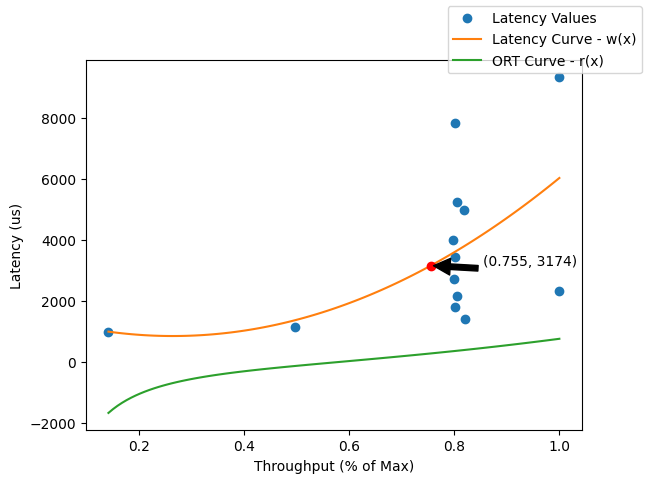

In [73]:
throughput_x_range = np.linspace(throughput.min(), throughput.max(), 100)
latency_mathed = latency_curve(throughput_x_range)


# Find the value of latency_mathed at x% of the way along the line
point_idx = int(x * len(latency_mathed))
x_val = throughput_x_range[point_idx]
y_val = latency_mathed[point_idx]

response_time_vals = [overall_response_time(throughput_x_range, latency_mathed, x)/2 for x in throughput_x_range]

# Plot the throughput/latency curve and the response time curve
fig, ax1 = plt.subplots()


ax1.plot(throughput, latency, 'o', label='Latency Values')
ax1.plot(throughput_x_range, latency_mathed, '-', label='Latency Curve - w(x)')
ax1.set_xlabel('Throughput (% of Max)')
ax1.set_ylabel('Latency (us)')
ax1.tick_params(axis='y')

x_val = x * (throughput_x_range.max() - throughput_x_range.min()) + throughput_x_range.min()
y_val = latency_curve(x_val)
ax1.plot(x_val, y_val, 'ro')
ax1.annotate(f'({x_val:.3f}, {y_val:.0f})', xy=(x_val, y_val), xytext=(x_val + .1, y_val + 0.01), arrowprops=dict(facecolor='black', shrink=0.05))


# ax2 = ax1.twinx()

ax1.plot(throughput_x_range, response_time_vals, label='ORT Curve - r(x)')
# ax2.set_ylabel('Response Time (ms)')
# ax2.tick_params(axis='y')

fig.legend(loc='upper right')
plt.show()



